# 03_Modeling

https://scikit-learn.org/stable/modules/mixture.html

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import umap
import joblib
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from visualization import compare_gmm_params,plot_gmm_metrics_comparison

c:\Users\julga\anaconda3\envs\consul-ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
df = pd.read_csv('../data/preprocessed_datasets/windowed_dataset_cleaned.csv')
X = df[df.columns.difference(['is_attack'])]
y = df['is_attack']

## GMM

### Selecting Hyperparameters

Aplicando transformaciones a los datos...
Procesando n_components=2...
Procesando n_components=3...
Procesando n_components=4...
Procesando n_components=5...
Procesando n_components=6...
Procesando n_components=7...


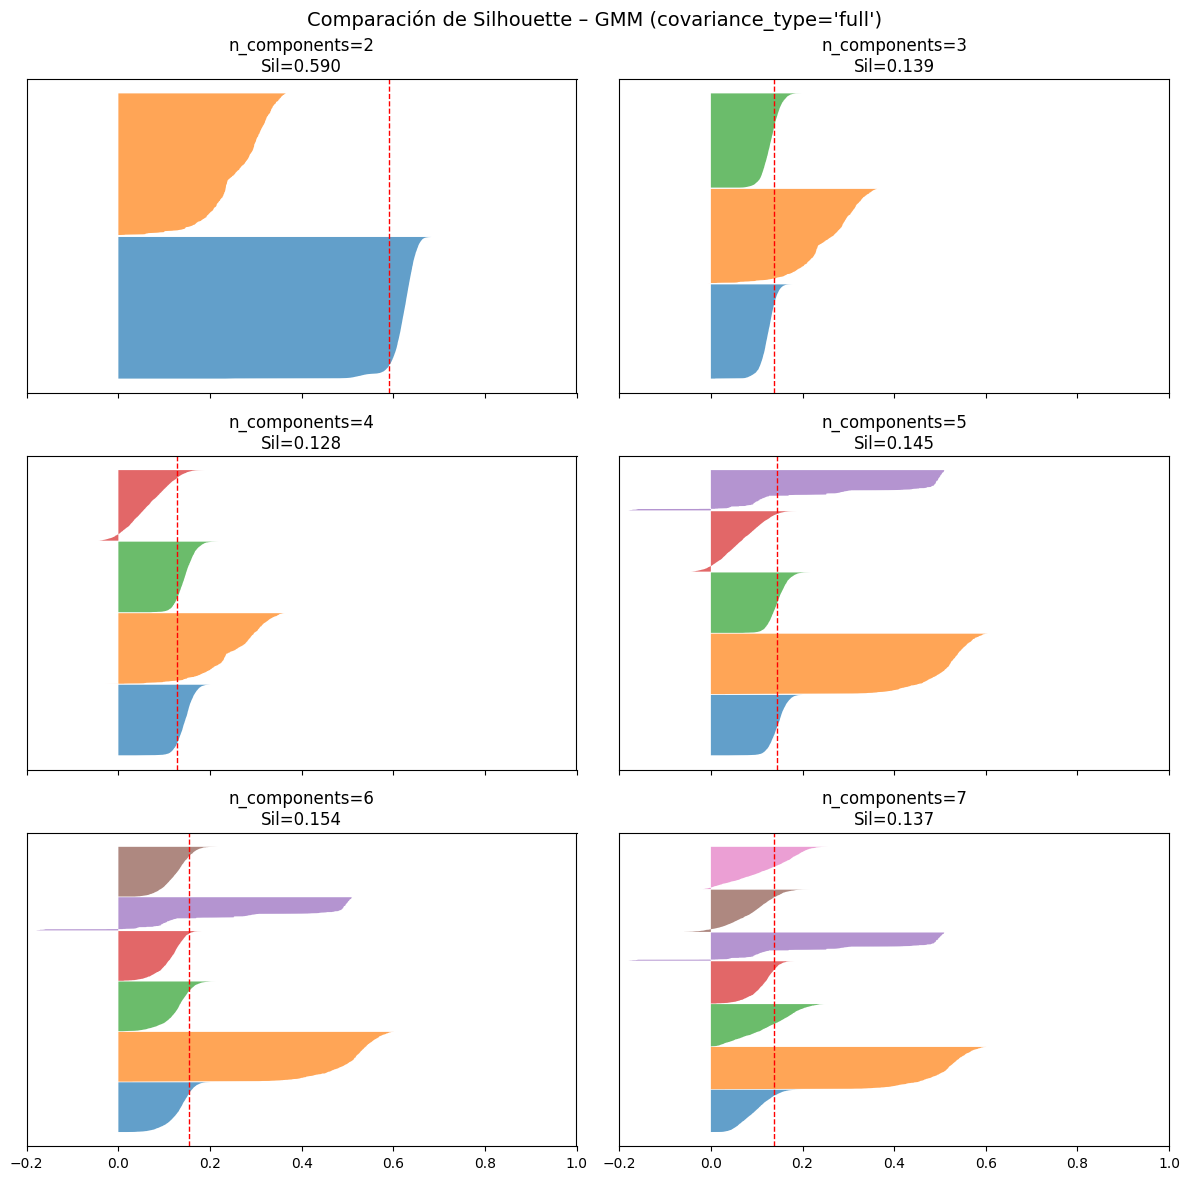

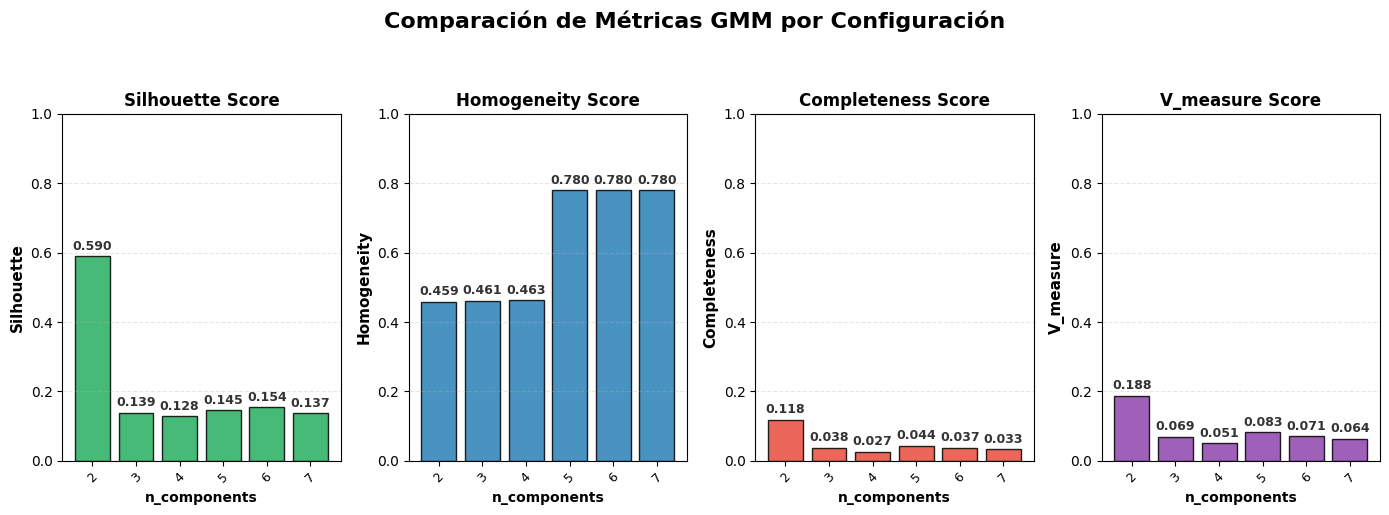

In [3]:
param_grid = [2, 3, 4, 5, 6, 7]

# Ejecuta la comparación
results, fig1 = compare_gmm_params(
    X, 
    param_grid,
    y_true=y,  # opcional
    covariance_type='full',  # puedes cambiar a 'tied', 'diag', 'spherical'
    random_state=42
)
plt.show()

# Visualiza las métricas
fig2 = plot_gmm_metrics_comparison(results)
plt.show()

- We aim to select the hyperparameters that maximize performance across multiple evaluation metrics. Based on the comparison, **n_components=2** appears to be the optimal choice, as it achieves the highest **Silhouette Score** (~0.75), indicating well-defined and compact clusters.
- Regarding the supervised metrics, the **Homogeneity** score is notably low across all configurations, suggesting that the clusters do not purely contain samples from a single class. However, **Completeness** is relatively high, meaning that samples of the same class tend to be grouped together in the same cluster.
- Looking at the **Silhouette Graphics**, we observe that with `n_components=2`, both clusters show mostly positive silhouette values with a consistent shape, while configurations with more components (3+) show smaller clusters with many points having negative silhouette scores—indicating that those points are closer to neighboring clusters than to their own assigned cluster.

### Fitting the model

In [5]:
gmm_pipeline = Pipeline([
    ('power_transform', PowerTransformer(method='yeo-johnson', standardize=False)),  # Normaliza distribuciones asimétricas
    ('scaler', StandardScaler()),  # Escala a media=0, std=1
    ('gmm', GaussianMixture(
        n_components=2,  # número de clusters
        covariance_type='full',  # 'full', 'tied', 'diag', 'spherical' full: clusters = elipses libres
        reg_covar=1e-6,
        random_state=42
    ))
])

gmm_labels = gmm_pipeline.fit_predict(X)

### Visualizing the results: PCA & UMAP

In [8]:
pca_pipeline = Pipeline([
    ('power_transform', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler()),
    ('pca',PCA(n_components=2, random_state=42))
])
X_pca = pca_pipeline.fit_transform(X)

print("Varianza explicada por componente:")
print(pca_pipeline.named_steps["pca"].explained_variance_ratio_)
print("Varianza total explicada:", pca_pipeline.named_steps["pca"].explained_variance_ratio_.sum())

df_pca = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'GMM_cluster': gmm_labels.astype(str),
    'is_attack': y
})

fig = px.scatter(
    df_pca,
    x='PCA1',
    y='PCA2',
    color='GMM_cluster',
    title="PCA (2D) – Gaussian Mixture clusters",
    width=900,
    hover_data=['is_attack'],
    height=700
)

fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(legend_title_text='GMM Cluster')

fig.show()


Varianza explicada por componente:
[0.32903906 0.10611044]
Varianza total explicada: 0.43514949434183553


- The PCA projection shows two well-separated clusters along the first principal component (PCA1). Cluster 0 forms a dense concentration on one side, while Cluster 1 appears more spread out on the opposite side. However, when hovering over the points, we can observe that both attack and legitimate traffic samples coexist within right corner of Cluster 1.

In [9]:
import umap

umap_pipeline = Pipeline([
    ('power_transform', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler()),
    ('umap', umap.UMAP(
        n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=42
    ))
])


X_umap = umap_pipeline.fit_transform(X)


c:\Users\julga\anaconda3\envs\consul-ml\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\julga\anaconda3\envs\consul-ml\Lib\site-packages\umap\spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

c:\Users\julga\anaconda3\envs\consul-ml\Lib\site-packages\umap\spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

c:\Users\julga\anaconda3\envs\consul-ml\Lib\site-packages\umap\spectral.py:548: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or ji

In [11]:
import plotly.express as px

df_vis = df.copy()
df_vis['UMAP1'] = X_umap[:, 0]
df_vis['UMAP2'] = X_umap[:, 1]
df_vis['gmm_cluster'] = gmm_labels.astype(str)

fig = px.scatter(
    df_vis,
    x='UMAP1',
    y='UMAP2',
    color='gmm_cluster',
    hover_data=['is_attack', 'burst_score_max', 'conn_count_10s_max', 'recent_activity_score_std', 'time_since_container_start_std', 'total_conn_from_ip_std'],
    title="UMAP + Gaussian Mixture clusters",
    width=900,
    height=700
)

fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(legend_title_text='GMM cluster')

fig.show()


- The UMAP projection reveals a large central mass corresponding to Cluster 0 and a smaller, more elongated region for Cluster 1. UMAP preserves local neighborhood structure, making it easier to identify dense regions and outliers in the data.
- When inspecting the hover data, we notice that attack samples are positioned very close to some legitimate traffic instances within Cluster 1. The model groups them together due to their similar feature patterns and is unable to distinguish between them (zoom into the right peripheral regions to observe this overlap).

### Semisupervised results

In [12]:
pd.crosstab(df['is_attack'], gmm_labels)

col_0,0,1
is_attack,,
0,21930,1729
1,6,340


- The cross-tabulation confirms what the visualizations suggested: almost all attack samples (`is_attack=1`) are assigned to Cluster 1, while Cluster 0 contains predominantly legitimate traffic. However, Cluster 1 also includes a significant number of legitimate samples, indicating that the model groups attacks together with certain types of normal traffic. Let's analyze Cluster 1 in more detail to understand which features cause this overlap.

### Visualizng by cluster

In [13]:
# Define the two GMM clusters
cluster0 = df_vis[df_vis['gmm_cluster'] == '0'].copy()
cluster1 = df_vis[df_vis['gmm_cluster'] == '1'].copy()

# Split cluster1 into legit and attack
cluster1_legit = cluster1[cluster1['is_attack'] == 0].copy()
cluster1_attack = cluster1[cluster1['is_attack'] == 1].copy()

# Count real attacks (for transparency)
n_attacks_c0 = cluster0['is_attack'].sum()  # should be 6
n_legit_c1 = len(cluster1_legit)
n_attack_c1 = len(cluster1_attack)

print(f"Cluster 0: {len(cluster0):>6} samples ({n_attacks_c0} attacks) → treated as LEGITIMATE")
print(f"Cluster 1 - Legitimate: {n_legit_c1:>6} samples")
print(f"Cluster 1 - Attack:     {n_attack_c1:>6} samples")
print("="*80)

# Key features for comparison
features = [
    'burst_score_max',
    'conn_count_10s_max',
    'conn_count_60s_max',
    'ja3_frequency_mean',
    'recent_activity_score_std',
    'time_since_container_start_std',
    'bytes_ratio_mean'
]

# Central tendency: mean for all groups
comparison_data = []
for feature in features:
    comparison_data.append({
        'Feature': feature,
        'C0 (Legit)': cluster0[feature].mean(),
        'C1_Legit': cluster1_legit[feature].mean(),
        'C1_Attack': cluster1_attack[feature].mean()
    })

# Variability: standard deviation for all groups
std_data = []
for feature in features:
    std_data.append({
        'Feature': feature,
        'C0 (Legit)': cluster0[feature].std(),
        'C1_Legit': cluster1_legit[feature].std(),
        'C1_Attack': cluster1_attack[feature].std()
    })

comparison_df = pd.DataFrame(comparison_data)
std_df = pd.DataFrame(std_data)

print("\nCOMPARISON TABLE (CENTRAL TENDENCY):")
print("(C0 treated as pure legitimate; C1 split by true label)")
print("="*80)
print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

print("\nSTANDARD DEVIATION (VARIABILITY) BY GROUP:")
print("="*80)
print(std_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("="*80)

Cluster 0:  21936 samples (6 attacks) → treated as LEGITIMATE
Cluster 1 - Legitimate:   1729 samples
Cluster 1 - Attack:        340 samples

COMPARISON TABLE (CENTRAL TENDENCY):
(C0 treated as pure legitimate; C1 split by true label)
                       Feature  C0 (Legit)  C1_Legit  C1_Attack
               burst_score_max      0.0011    0.1134     1.0000
            conn_count_10s_max      1.0330    1.9717     7.2676
            conn_count_60s_max      1.4664    2.5246     7.3500
            ja3_frequency_mean     68.1104   68.7149   392.5147
     recent_activity_score_std      0.0000    0.0736     0.2769
time_since_container_start_std      0.0000    2.2365     0.0000
              bytes_ratio_mean      0.5393    0.5164     0.2206

STANDARD DEVIATION (VARIABILITY) BY GROUP:
                       Feature  C0 (Legit)  C1_Legit  C1_Attack
               burst_score_max      0.0331    0.3171     0.0000
            conn_count_10s_max      0.1855    0.3876     2.2555
            conn_c

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Features más discriminantes
discriminant_features = [
    'ja3_frequency_mean',
    'conn_count_10s_max', 
    'burst_score_max',
    'bytes_ratio_mean',
    'recent_activity_score_std'
]

def format_value(v):
    if v == 0:
        return "0"
    elif abs(v) >= 1e-3:
        return f"{v:.4f}"
    else:
        return f"{v:.2e}"

fig_bars = make_subplots(
    rows=2, cols=3,
    subplot_titles=[f.replace('_', ' ').title() for f in discriminant_features],
    vertical_spacing=0.12,
    horizontal_spacing=0.10
)

# Updated group names (3 groups only)
group_names = ['C0 (Legit)', 'C1_Legit', 'C1_Attack']
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # removed blue for C1

for idx, feature in enumerate(discriminant_features):
    row = idx // 3 + 1
    col = idx % 3 + 1
    
    # Fetch values from the updated comparison_df
    values = [
        comparison_df[comparison_df['Feature'] == feature]['C0 (Legit)'].values[0],
        comparison_df[comparison_df['Feature'] == feature]['C1_Legit'].values[0],
        comparison_df[comparison_df['Feature'] == feature]['C1_Attack'].values[0]
    ]
    
    # Adjust Y-axis range
    max_val = max(values)
    y_max = max(0.001, max_val * 1.2) if max_val > 0 else 0.001
    fig_bars.update_yaxes(range=[0, y_max], row=row, col=col)
    
    for i, (group, value, color) in enumerate(zip(group_names, values, colors)):
        fig_bars.add_trace(
            go.Bar(
                x=[group],
                y=[value],
                name=group if idx == 0 else None,
                marker_color=color,
                text=[format_value(value)],
                textposition='outside',
                textfont=dict(size=10, color='black'),
                showlegend=(idx == 0),
                hovertemplate=f'<b>{group}</b><br>{feature}: %{{y:.6f}}<extra></extra>'
            ),
            row=row, col=col
        )

fig_bars.update_xaxes(showticklabels=True)  # optional: show group labels
fig_bars.update_yaxes(title_text="Valor", col=1)

fig_bars.update_layout(
    title_text='Features Clave: Comparación de los 3 Grupos',
    title_font_size=16,
    height=600,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    plot_bgcolor='white',
    paper_bgcolor='#f8f9fa'
)

fig_bars.show()

## Conclusions

#### Cluster 0: Legitimate baseline traffic
- This is the largest cluster, containing the majority of samples. According to the comparison table and bar charts, these samples exhibit the lowest values across most features, representing the normal, routine traffic to Consul.

- The **burst_score_max** and **conn_count_10s_max** values are near zero, indicating a steady, non-bursty traffic pattern with few simultaneous connections. Similarly, **conn_count_60s_max** remains low, confirming that connection rates are stable over longer time windows.

- The **ja3_frequency_mean** is significantly lower compared to Cluster 1. Since our services use HttpxClient to query Consul, the TLS handshake is reused within persistent connections. This results in fewer unique JA3 fingerprints per time window, as there are not many new connections being established.

- The **bytes_ratio_mean** is relatively higher in this cluster, suggesting balanced request-response sizes typical of standard service discovery queries.

In conclusion, Cluster 0 represents routine GET requests to Consul endpoints like *(https://consul_ip/v1/catalog/service/order)* for specific service lookups or periodic healthchecks from services operating under normal conditions.

#### Cluster 1: Intense traffic (Legitimate + Attacks)
- This is the smaller cluster but contains both legitimate samples and all attack instances. The comparison table shows that both C1_Legit and C1_Attack exhibit significantly higher values for **burst_score_max**, **conn_count_10s_max**, and **ja3_frequency_mean** compared to Cluster 0.

- **Legitimate samples in Cluster 1 (C1_Legit)**: These show elevated **burst_score** and **conn_count** values, likely representing more intensive operations such as service (re)registration, rapid healthchecks after a service startup, or inter-service communication bursts (e.g., when services repeatedly query Consul without caching).

- **Attack samples in Cluster 1 (C1_Attack)**: These exhibit the highest **ja3_frequency_mean** values, which is characteristic of automated tools creating new connections repeatedly with the same TLS fingerprint. The **bytes_ratio_mean** is notably lower for attacks—since *bytes_ratio = orig_bytes / resp_bytes*, this suggests small requests yielding large responses, consistent with scanning patterns like *(https://consul_ip/v1/catalog/services)* or *(https://consul_ip/v1/catalog/nodes)*.

## Save model

In [ ]:
joblib.dump(gmm_pipeline, "../models/gmm_model.joblib")

StandardScaler()
